## MultiClass Calibration using SplieCalib
### Example: MNIST Random Forest model data

This notebook is to demonstrate how to do multiclass calibration using SplineCalib functionality in the ml_insights package.  We will use PCA to extract components from images, run a random forest model, and then demonstrate how to properly calibrate the predictions from the Random Forest Model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import accuracy_score, confusion_matrix


import ml_insights as mli

In [2]:
# try `!pip install keras` if keras not found
# We use keras just to get the mnist data
# You can also download MNIST at yann.lecun.com/exdb/mnist

from keras.datasets import mnist


Using TensorFlow backend.


## Classifying Digits Using PCA and the MNIST data

We will use PCA to perform dimensionality reduction on the MNIST handwritten digit data.  We explore the *eigenvectors* and further show how the decomposition can be used to capture the salient dimensions of the data necessary to classify the digits.

#### Load the Data, Examine and Explore

In [3]:
## Load in the MNIST data
(trainX, y_train), (testX, y_test) = mnist.load_data()

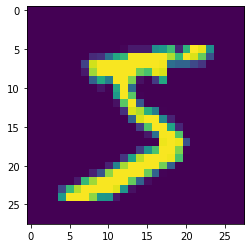

In [4]:
## Here is an example image
plt.imshow(trainX[0])

In [5]:
# let's reshape the data so that the pixel values are 784 distinct columns

X_train = trainX.reshape(60000,28*28)
X_test = testX.reshape(10000,28*28)
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

In [6]:
## Scale the values before doing PCA
s = StandardScaler()
X_train_std = s.fit_transform(X_train)
X_test_std = s.transform(X_test)

In [7]:
## Run a PCA on the standardized values
pca_proc = PCA(n_components=30)
pca_proc.fit(X_train_std)

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [8]:
# Transform the data - after this we have 30 PCA features to use in our Random Forest model

X_train_pca = pca_proc.transform(X_train_std)
X_test_pca = pca_proc.transform(X_test_std)
X_train_pca = pd.DataFrame(X_train_pca)
X_train_pca.columns = ['pca_vec_'+str(j) for j in range(X_train_pca.shape[1])]
X_test_pca = pd.DataFrame(X_test_pca)
X_test_pca.columns = ['pca_vec_'+str(j) for j in range(X_test_pca.shape[1])]


In [9]:
# Train our Random Forest model

rf1 = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
rf1.fit(X_train_pca, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [10]:
# Get the predicted "probabilities" (vote percentages from the RF)
# Also, use the argmax to get the "hard" prediction (most likely digit)

test_probs = rf1.predict_proba(X_test_pca)
hard_preds = np.argmax(test_probs, axis=1)

In [11]:
# Evaluate the model in terms of log_loss and accuracy

log_loss(y_test, test_probs), accuracy_score(y_test, hard_preds)

(0.30467127217827117, 0.942)

In [12]:
# Generate cross_validated predictions on your training data
# This will be the data your calibration object "learns" from

cv_train_preds = mli.cv_predictions(rf1, X_train_pca, y_train)

In [13]:
# Define the calibration object and fit it to the cross-validated predictions

calib_mc = mli.SplineCalib()
calib_mc.fit(cv_train_preds, y_train, verbose=True)

Calibrating Class 0
Calibrating Class 1
Calibrating Class 2
Calibrating Class 3
Calibrating Class 4
Calibrating Class 5
Calibrating Class 6
Calibrating Class 7
Calibrating Class 8
Calibrating Class 9


In [14]:
# Calibrate the previous predictions from the model

test_probs_calibrated = calib_mc.calibrate(test_probs)

In [15]:
# Compare the previous (uncalibrated) log_loss with the calibrated one

log_loss(y_test, test_probs), log_loss(y_test, test_probs_calibrated)

(0.30467127217827117, 0.18139765413983105)

In [16]:
# Make hard predictions based on the calibrated probability values
# In multiclass problems, calibration can often improve accuracy

hard_preds_calib = np.argmax(test_probs_calibrated, axis=1)

In [17]:
# We see an increase in accuracy...

accuracy_score(y_test, hard_preds), accuracy_score(y_test, hard_preds_calib)

(0.942, 0.943)

## Assessing the Calibration
SplineCalib (and the ml_insights package) also contains some plots and tools to help you assess the quality of your calibration.  While the default settings generally work fairly well, there are adjustments that can be made.

Below we see the calibration curves plotted on top of the reliability diagrams.  We see that the calibration curves do a good job of fitting the empirical probabilities.  Note also that the calibration curves are noticeably different for different classes.

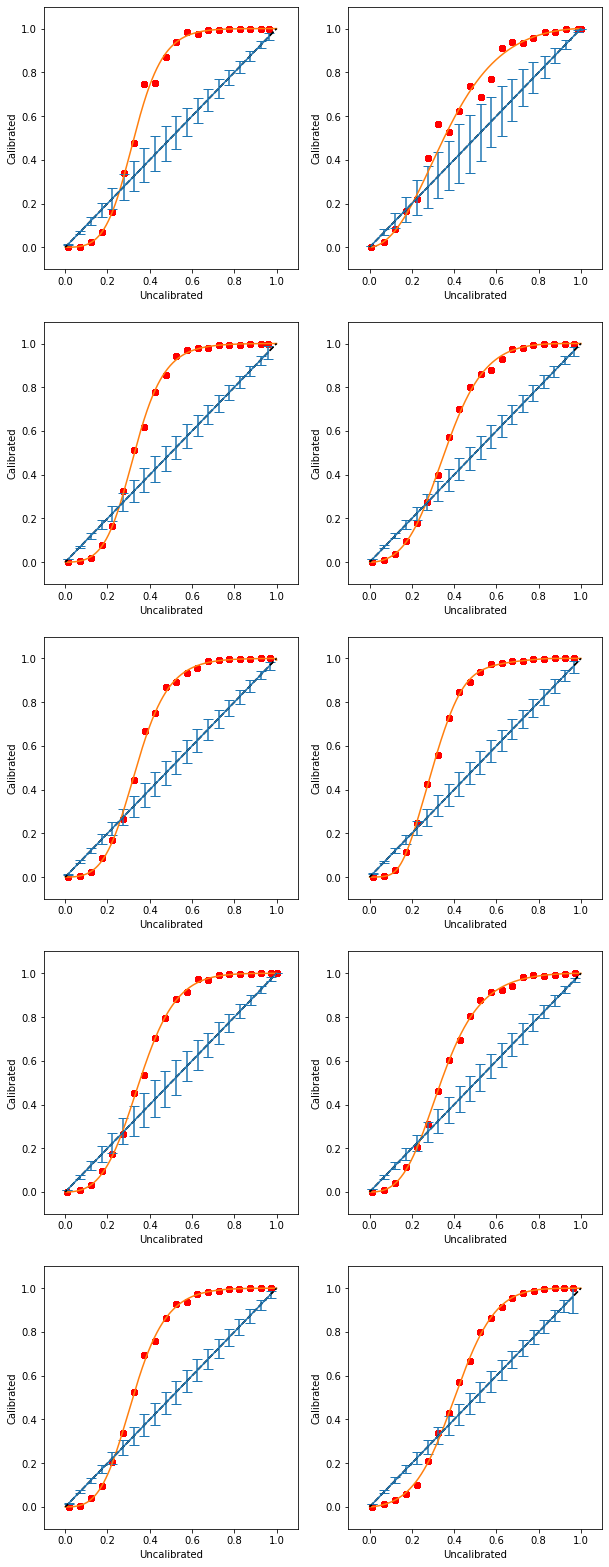

In [18]:
plt.figure(figsize=(10,28))
for i in range(10):
    plt.subplot(5,2,i+1)
    mli.plot_reliability_diagram((y_train==i).astype(int), cv_train_preds[:,i]);
    calib_mc.show_calibration_curve(class_num=i)

Next, we see how the log_loss changes with the regularization parameter when we fit the spline.  The vertical line indicates the chosen regularization value.  For these plots, smaller values indicate **more** regularization.  (SplineCalib errs on the side of more regularization).  If the curve were still sloping downward at the chosen value, this might indicate we need to widen the range of regularization parameter with the `reg_param_vec` argument in SplineCalib.

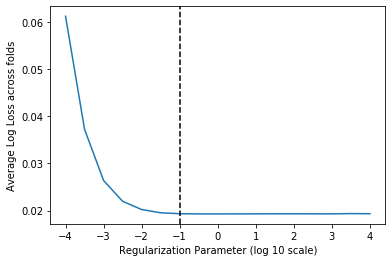

In [19]:
calib_mc.show_spline_reg_plot(class_num=0)

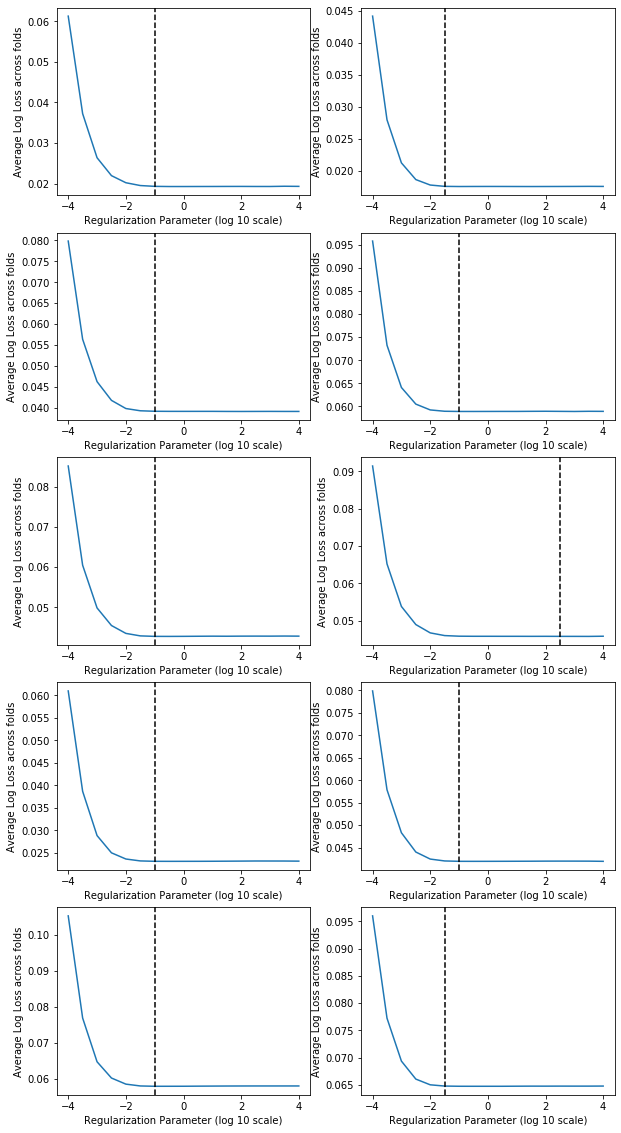

In [20]:
# Plot these curves for all classes

plt.figure(figsize=(10,20))
for i in range(10):
    plt.subplot(5,2,i+1)
    calib_mc.show_spline_reg_plot(class_num=i)